<a href="https://colab.research.google.com/github/arash-am/Media-Competition/blob/main/Main/In_order/Figure2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np # used for arrays
import gym # pull the environment
import time # to get the times
import math # needed for calculations
import torch
import matplotlib.pyplot as plt
import time  # Import the time module for timing
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Part A-No Misinformation

In [1]:


class Opinon_w_media(torch.nn.Module):
    def __init__(self, device, N=1000, M=10, terminal_time=500,
                 bM=5, b=25, noise_level=0.1, duration=50, eta=1, eta2=2,
                 h=torch.tensor(0.1),num_batches=10,bet1=3,bet2=2):
        super().__init__()
        self.batch_size = num_batches
        self.device = device
        self.N = N
        self.M = M
        self.terminal_time = terminal_time
        Beta = torch.distributions.beta.Beta(bet1, bet2)
        self.s = Beta.sample(sample_shape=(self.N,self.batch_size)).to(self.device)
        self.ym = torch.linspace(-1, 1, steps=self.M).to(self.device)
        self.noise_level = noise_level
        self.bM = bM
        self.b = b
        self.duration = duration
        self.eta = eta
        self.eta2 = eta2
        self.h = h.to(self.device)
        self.t=0
        self.action_dim=9
        self.pi=torch.tensor(np.pi,device=self.device)





    def reset(self):
        self.state = torch.cat([torch.rand((self.N,self.batch_size), device=self.device) * 2 - 1,
                                torch.ones((self.M,self.batch_size), device=self.device)])
        return self.state

    def dyn_step(self):
        rewards = torch.zeros((self.batch_size,), device=self.device)
        dones = torch.zeros((self.batch_size,), device=self.device, dtype=torch.bool)
        x, c= self.state[:self.N], self.state[self.N:]
        X=torch.zeros((self.terminal_time,self.N,self.batch_size),device=self.device)
        X[0,:,:]=x
        t=self.t
        gam=0.98
        rewards=0
        self.AEm=torch.zeros((self.N,self.batch_size,self.M),device=self.device)
        self.AEm_abs=torch.zeros((self.N,self.batch_size,self.M),device=self.device)
        for i in range(self.terminal_time):
            X[i,:,:]=x
            DM = self.ym-x[:,:,None]
            D = x - x[:, None]
            actions=torch.bernoulli(0.95-0.000000000005*env.ym**2).to(self.device)[None,:]
            # actions=torch.bernoulli(0.5+0.000000085*env.ym**2).to(self.device)[None,:]
            # actions=torch.bernoulli(torch.rand(self.M)).to(self.device)[None,:]
            # u_actions = actions[:int(self.M/2)]
            # v_actions =  actions[int(self.M/2):]
            # actions = torch.cat([u_actions, v_actions],dim=1)
            eta = self.eta
            eta2 = self.eta2
            AM = torch.exp(-self.bM * (1 + eta * actions[None,:,:]) * (1 + eta2 * (1 - c.t()[None,:,:])*(1-self.s[:,:,None])) * torch.abs(DM))
            self.AEm_abs += torch.exp(-self.bM * torch.abs(DM))* (1-actions[None,:,:])
            self.AEm += torch.exp(-self.bM * (1 + eta * actions[None,:,:]) * (1 + eta2 * (1 - c.t()[None,:,:])*(1-self.s[:,:,None])) * torch.abs(DM))* (1-actions[None,:,:])
            A = torch.exp(-self.b * torch.abs(D))
            t += 1
            # c = (c * (t - 1) + actions.t()) / t
            c= c*(gam)+actions.t()*(1-gam)
            x += self.h * ((torch.sum(A * D, dim=1) / torch.sum(A, dim=1)) + (torch.sum(AM * DM, dim=2) / torch.sum(AM, dim=2)))
            x += torch.sqrt(self.h) * torch.normal(0, self.noise_level, size=(self.N,self.batch_size), device=self.device)
            rewards += -1*torch.sin(x*self.pi/2).pow(5).sum().to(self.device)

        self.state=torch.cat([x,c])
        self.X=X
        self.c=c
        # print(c.mean(dim=1))
        self.t=t
        dones = dones | (t >= self.terminal_time)
        self.AM=AM
        return rewards, dones




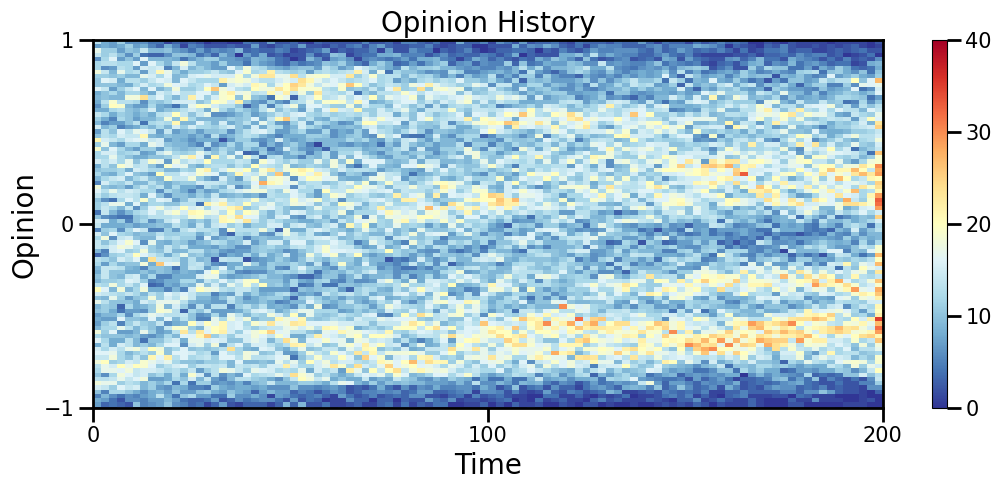

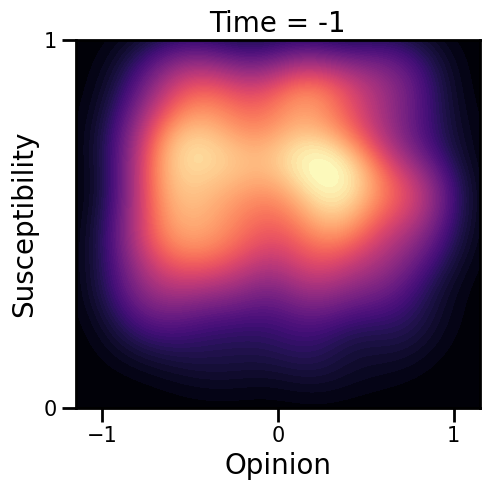

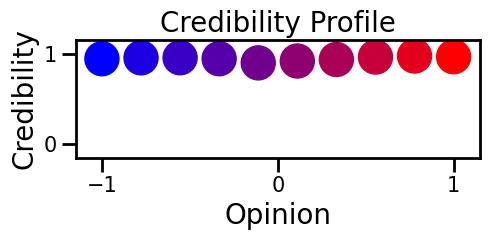

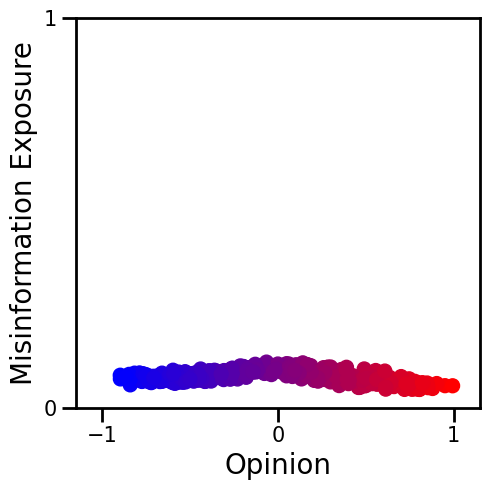

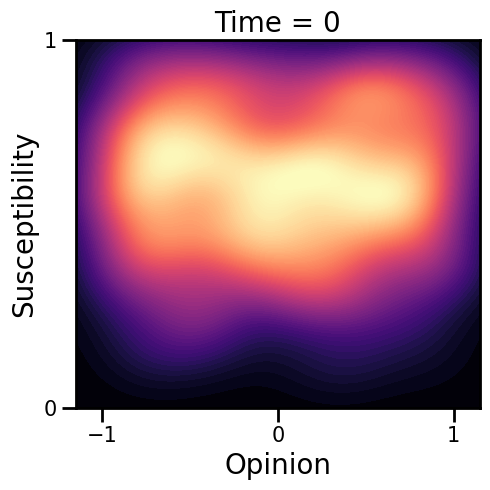

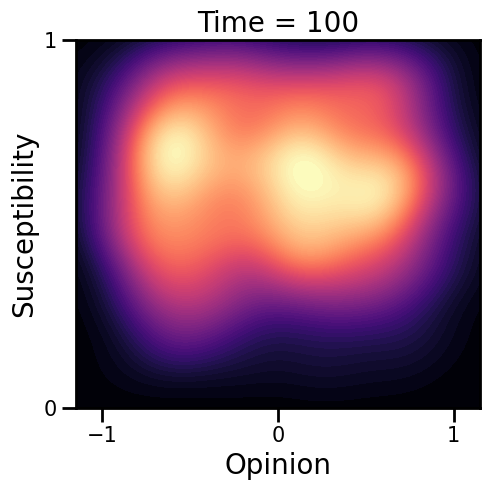

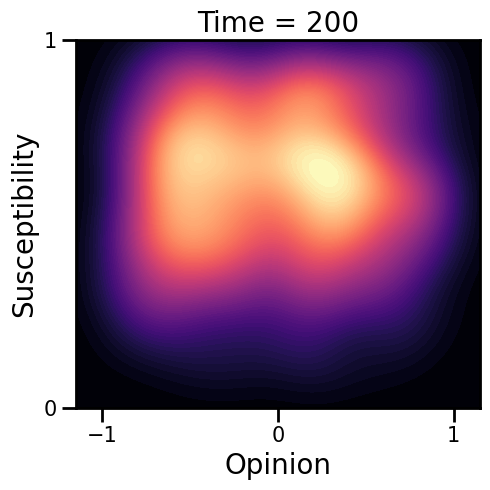

In [7]:
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list("custom_blue_red",[(0, 0, 1), (1, 0, 0)], N=100)


plt_type='Normal'
M=10
N=500
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
terminal_time=201
env = Opinon_w_media(device=device, N=N,
                              M=M, terminal_time=terminal_time,bM=5,b=20,noise_level=0.1,
                              duration=terminal_time,h=torch.tensor(.1),
                              num_batches=1,eta=1, eta2=2,
                              bet1=3,bet2=2)
env.reset()
reward, done = env.dyn_step()
X=env.X.squeeze().cpu().numpy()
Tvec=np.arange(X.shape[0])



fig,ax=plt.subplots(figsize=(11,5))
T=np.ones((1,N))*np.arange(X.shape[0])[:,None]
cax=sns.histplot(x=T.flatten(),y=X.flatten(),fill=True,cmap="RdYlBu_r",bins=100,thresh=None,ax=ax)
quadmesh = cax.collections[0]
quadmesh.set_clim(0, 40)
cbar = plt.colorbar(cax.collections[0], ax=ax,aspect=25)
cbar.ax.tick_params(labelsize=15, width=2, length=10)
cbar.ax.set_yticks([0,10,20,30,40])


ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.set_ylim(-1, 1)
ax.set_xlim(0, terminal_time-1)
ax.set_yticks([-1, 0, 1])
ax.set_xticks([0,100,200])
ax.set_xlabel("Time",fontsize=20)
ax.set_ylabel("Opinion",fontsize=20)
ax.set_title("Opinion History",fontsize=20)

plt.tight_layout()
plt.savefig("op_hist"+plt_type+".svg",dpi=300)
plt.show()


time_indices = [ -1]
fig, axes = plt.subplots(1, len(time_indices), figsize=(len(time_indices)*5, 5))  # Adjust the figure size as needed
ax=axes
# for ax, t_idx in zip(axes, time_indices):
t_idx=-1
sns.kdeplot(x=X[t_idx, :], y=env.s.squeeze().cpu().numpy(), fill=True, thresh=None, cmap="magma", levels=100, ax=ax)
# ax.set_xlim(-1, 1)
ax.set_xlim([-1.15 ,1.15])
ax.set_ylim(0, 1)
ax.set_xticks([-1, 0, 1])
ax.set_yticks([0, 1])
ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)

ax.set_title("Time = "+str(t_idx),fontsize=20)
ax.set_xlabel("Opinion",fontsize=20)
ax.set_ylabel("Susceptibility",fontsize=20)


plt.tight_layout()
plt.savefig("xs_kde200"+plt_type+".svg",dpi=300)
plt.show()




# cmap = plt.cm.coolwarm  # Choose blue-white-red colormap
# cmap = plt.cm.RdYlBu_r

fig,ax=plt.subplots(figsize=(5,2.5))
ax.scatter(env.ym.cpu(),env.c.cpu(),600,c=env.ym.cpu(),cmap=cmap,alpha=1)
ax.set_xlim([-1.15 ,1.15])
ax.set_ylim([-0.15, 1.15])
ax.set_xticks([-1, 0, 1])
ax.set_yticks([0, 1])
ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)

ax.set_title("Credibility Profile",fontsize=20)
ax.set_xlabel("Opinion",fontsize=20)
ax.set_ylabel("Credibility",fontsize=20)


plt.tight_layout()
plt.savefig("cx_circ"+plt_type+".svg",dpi=300)
plt.show()



fig,ax=plt.subplots(figsize=(5,5))


x=env.X.squeeze().cpu().numpy()[-1,:]
ax.scatter(y=env.AEm_abs.sum(axis=2).cpu().flatten().numpy()/(terminal_time-1),x=x,c=x,cmap=cmap,s=100,alpha=1)
# ax.set_xlim(-1, 1)
ax.set_xlim([-1.15 ,1.15])
ax.set_ylim(0, 1)
ax.set_xticks([-1, 0, 1])
ax.set_yticks([0, 1])
ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
# ax.set_title("Credibility Profile",fontsize=20)
ax.set_xlabel("Opinion",fontsize=20)
ax.set_ylabel("Misinformation Exposure",fontsize=20)


plt.tight_layout()
plt.savefig("Ex_"+plt_type+".svg",dpi=300)
plt.show()



t_idx=0
fig, ax = plt.subplots(1, len(time_indices), figsize=(len(time_indices)*5, 5))  # Adjust the figure size as needed
sns.kdeplot(x=X[t_idx, :], y=env.s.squeeze().cpu().numpy(), fill=True, thresh=None, cmap="magma", levels=100, ax=ax)
# ax.set_xlim(-1, 1)
ax.set_xlim([-1.15 ,1.15])
ax.set_ylim(0, 1)
ax.set_xticks([-1, 0, 1])
ax.set_yticks([0, 1])
ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)

ax.set_title("Time = "+str(t_idx),fontsize=20)
ax.set_xlabel("Opinion",fontsize=20)
ax.set_ylabel("Susceptibility",fontsize=20)

plt.tight_layout()
plt.savefig("xs_kde000"+plt_type+".svg",dpi=300)
plt.show()




t_idx=100
fig, ax = plt.subplots(1, len(time_indices), figsize=(len(time_indices)*5, 5))  # Adjust the figure size as needed
sns.kdeplot(x=X[t_idx, :], y=env.s.squeeze().cpu().numpy(), fill=True, thresh=None, cmap="magma", levels=100, ax=ax)
# ax.set_xlim(-1, 1)
ax.set_xlim([-1.15 ,1.15])
ax.set_ylim(0, 1)
ax.set_xticks([-1, 0, 1])
ax.set_yticks([0, 1])
ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.set_title("Time = "+str(t_idx),fontsize=20)
ax.set_xlabel("Opinion",fontsize=20)
ax.set_ylabel("Susceptibility",fontsize=20)

plt.tight_layout()
plt.savefig("xs_kde100"+plt_type+".svg",dpi=300)
plt.show()


t_idx=200
fig, ax = plt.subplots(1, len(time_indices), figsize=(len(time_indices)*5, 5))  # Adjust the figure size as needed
sns.kdeplot(x=X[t_idx, :], y=env.s.squeeze().cpu().numpy(), fill=True, thresh=None, cmap="magma", levels=100, ax=ax)
# ax.set_xlim(-1, 1)
ax.set_xlim([-1.15 ,1.15])
ax.set_ylim(0, 1)
ax.set_xticks([-1, 0, 1])
ax.set_yticks([0, 1])
ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.set_title("Time = "+str(t_idx),fontsize=20)
ax.set_xlabel("Opinion",fontsize=20)
ax.set_ylabel("Susceptibility",fontsize=20)

plt.tight_layout()
plt.savefig("xs_kde100"+plt_type+".svg",dpi=300)
plt.show()


# Part B - Real-word Crediblity *Profile*

In [12]:


class Opinon_w_media(torch.nn.Module):
    def __init__(self, device, N=1000, M=10, terminal_time=500,
                 bM=5, b=25, noise_level=0.1, duration=50, eta=1, eta2=2,
                 h=torch.tensor(0.1),num_batches=10,bet1=3,bet2=2):
        super().__init__()
        self.batch_size = num_batches
        self.device = device
        self.N = N
        self.M = M
        self.terminal_time = terminal_time
        Beta = torch.distributions.beta.Beta(bet1, bet2)
        self.s = Beta.sample(sample_shape=(self.N,self.batch_size)).to(self.device)
        self.ym = torch.linspace(-1, 1, steps=self.M).to(self.device)
        self.noise_level = noise_level
        self.bM = bM
        self.b = b
        self.duration = duration
        self.eta = eta
        self.eta2 = eta2
        self.h = h.to(self.device)
        self.t=0
        self.action_dim=9
        self.pi=torch.tensor(np.pi,device=self.device)





    def reset(self):
        self.state = torch.cat([torch.rand((self.N,self.batch_size), device=self.device) * 2 - 1,
                                torch.ones((self.M,self.batch_size), device=self.device)])
        return self.state

    def dyn_step(self):
        rewards = torch.zeros((self.batch_size,), device=self.device)
        dones = torch.zeros((self.batch_size,), device=self.device, dtype=torch.bool)
        x, c= self.state[:self.N], self.state[self.N:]
        X=torch.zeros((self.terminal_time,self.N,self.batch_size),device=self.device)
        X[0,:,:]=x
        t=self.t
        gam=0.98
        rewards=0
        self.AEm=torch.zeros((self.N,self.batch_size,self.M),device=self.device)
        self.AEm_abs=torch.zeros((self.N,self.batch_size,self.M),device=self.device)
        for i in range(self.terminal_time):
            X[i,:,:]=x
            DM = self.ym-x[:,:,None]
            D = x - x[:, None]
            actions=torch.bernoulli(1-.95*env.ym**2).to(self.device)[None,:]

            eta = self.eta
            eta2 = self.eta2
            AM = torch.exp(-self.bM * (1 + eta * actions[None,:,:]) * (1 + eta2 * (1 - c.t()[None,:,:])*(1-self.s[:,:,None])) * torch.abs(DM))
            self.AEm_abs += torch.exp(-self.bM * torch.abs(DM))* (1-actions[None,:,:])
            self.AEm += torch.exp(-self.bM * (1 + eta * actions[None,:,:]) * (1 + eta2 * (1 - c.t()[None,:,:])*(1-self.s[:,:,None])) * torch.abs(DM))* (1-actions[None,:,:])
            A = torch.exp(-self.b * torch.abs(D))
            t += 1
            # c = (c * (t - 1) + actions.t()) / t
            c= c*(gam)+actions.t()*(1-gam)
            x += self.h * ((torch.sum(A * D, dim=1) / torch.sum(A, dim=1)) + (torch.sum(AM * DM, dim=2) / torch.sum(AM, dim=2)))
            x += torch.sqrt(self.h) * torch.normal(0, self.noise_level, size=(self.N,self.batch_size), device=self.device)
            rewards += -1*torch.sin(x*self.pi/2).pow(5).sum().to(self.device)

        self.state=torch.cat([x,c])
        self.X=X
        self.c=c
        # print(c.mean(dim=1))
        self.t=t
        dones = dones | (t >= self.terminal_time)
        self.AM=AM
        return rewards, dones




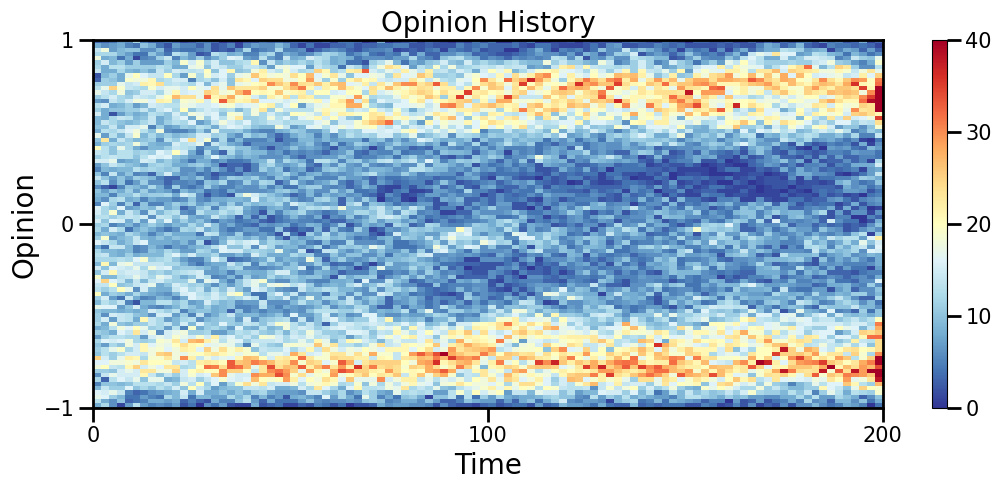

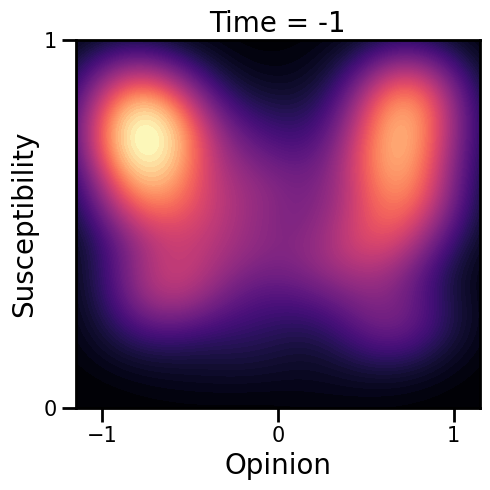

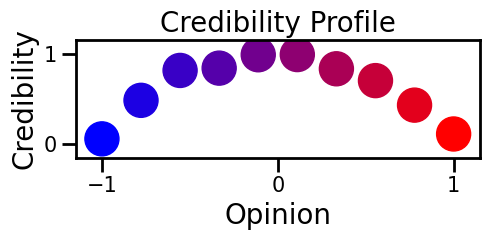

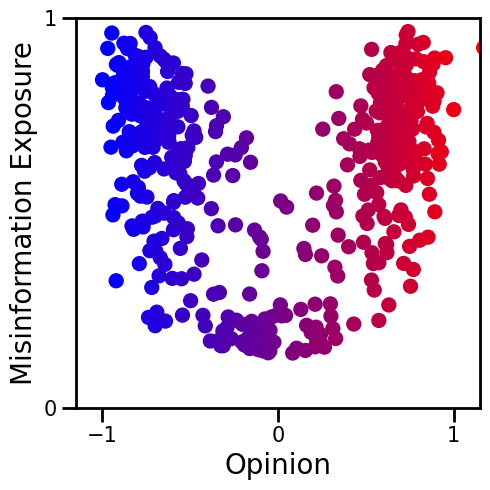

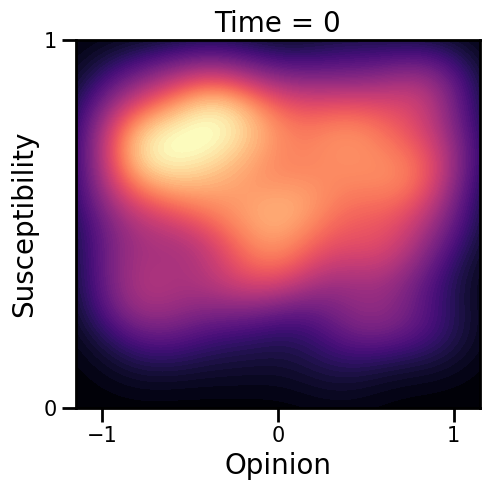

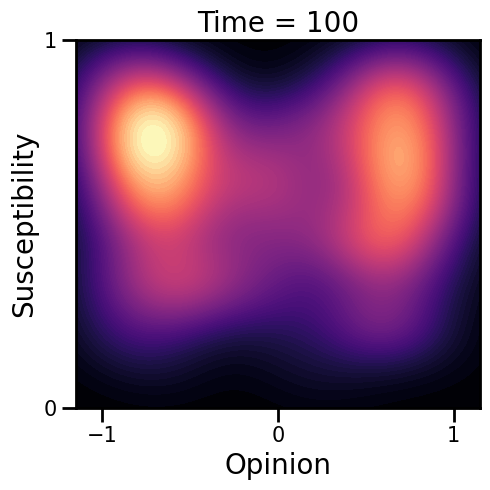

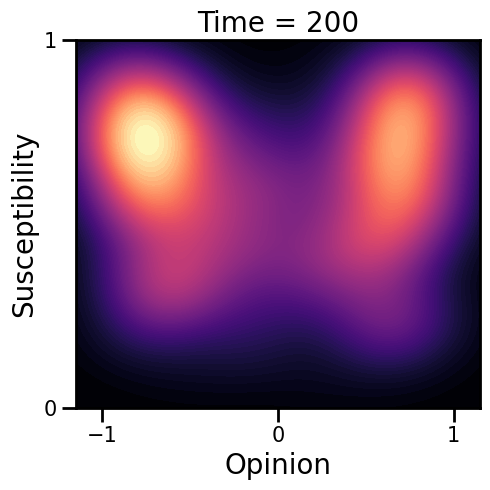

In [13]:
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list("custom_blue_red",[(0, 0, 1), (1, 0, 0)], N=100)


plt_type='Normal'
M=10
N=500
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
terminal_time=201
env = Opinon_w_media(device=device, N=N,
                              M=M, terminal_time=terminal_time,bM=5,b=20,noise_level=0.1,
                              duration=terminal_time,h=torch.tensor(.1),
                              num_batches=1,eta=1, eta2=2,
                              bet1=3,bet2=2)
env.reset()
reward, done = env.dyn_step()
X=env.X.squeeze().cpu().numpy()
Tvec=np.arange(X.shape[0])



fig,ax=plt.subplots(figsize=(11,5))
T=np.ones((1,N))*np.arange(X.shape[0])[:,None]
cax=sns.histplot(x=T.flatten(),y=X.flatten(),fill=True,cmap="RdYlBu_r",bins=100,thresh=None,ax=ax)
quadmesh = cax.collections[0]
quadmesh.set_clim(0, 40)
cbar = plt.colorbar(cax.collections[0], ax=ax,aspect=25)
cbar.ax.tick_params(labelsize=15, width=2, length=10)
cbar.ax.set_yticks([0,10,20,30,40])


ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.set_ylim(-1, 1)
ax.set_xlim(0, terminal_time-1)
ax.set_yticks([-1, 0, 1])
ax.set_xticks([0,100,200])
ax.set_xlabel("Time",fontsize=20)
ax.set_ylabel("Opinion",fontsize=20)
ax.set_title("Opinion History",fontsize=20)

plt.tight_layout()
plt.savefig("op_hist"+plt_type+".svg",dpi=300)
plt.show()


time_indices = [ -1]
fig, axes = plt.subplots(1, len(time_indices), figsize=(len(time_indices)*5, 5))  # Adjust the figure size as needed
ax=axes
# for ax, t_idx in zip(axes, time_indices):
t_idx=-1
sns.kdeplot(x=X[t_idx, :], y=env.s.squeeze().cpu().numpy(), fill=True, thresh=None, cmap="magma", levels=100, ax=ax)
# ax.set_xlim(-1, 1)
ax.set_xlim([-1.15 ,1.15])
ax.set_ylim(0, 1)
ax.set_xticks([-1, 0, 1])
ax.set_yticks([0, 1])
ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)

ax.set_title("Time = "+str(t_idx),fontsize=20)
ax.set_xlabel("Opinion",fontsize=20)
ax.set_ylabel("Susceptibility",fontsize=20)


plt.tight_layout()
plt.savefig("xs_kde200"+plt_type+".svg",dpi=300)
plt.show()




# cmap = plt.cm.coolwarm  # Choose blue-white-red colormap
# cmap = plt.cm.RdYlBu_r

fig,ax=plt.subplots(figsize=(5,2.5))
ax.scatter(env.ym.cpu(),env.c.cpu(),600,c=env.ym.cpu(),cmap=cmap,alpha=1)
ax.set_xlim([-1.15 ,1.15])
ax.set_ylim([-0.15, 1.15])
ax.set_xticks([-1, 0, 1])
ax.set_yticks([0, 1])
ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)

ax.set_title("Credibility Profile",fontsize=20)
ax.set_xlabel("Opinion",fontsize=20)
ax.set_ylabel("Credibility",fontsize=20)


plt.tight_layout()
plt.savefig("cx_circ"+plt_type+".svg",dpi=300)
plt.show()



fig,ax=plt.subplots(figsize=(5,5))


x=env.X.squeeze().cpu().numpy()[-1,:]
ax.scatter(y=env.AEm_abs.sum(axis=2).cpu().flatten().numpy()/(terminal_time-1),x=x,c=x,cmap=cmap,s=100,alpha=1)
# ax.set_xlim(-1, 1)
ax.set_xlim([-1.15 ,1.15])
ax.set_ylim(0, 1)
ax.set_xticks([-1, 0, 1])
ax.set_yticks([0, 1])
ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
# ax.set_title("Credibility Profile",fontsize=20)
ax.set_xlabel("Opinion",fontsize=20)
ax.set_ylabel("Misinformation Exposure",fontsize=20)


plt.tight_layout()
plt.savefig("Ex_"+plt_type+".svg",dpi=300)
plt.show()



t_idx=0
fig, ax = plt.subplots(1, len(time_indices), figsize=(len(time_indices)*5, 5))  # Adjust the figure size as needed
sns.kdeplot(x=X[t_idx, :], y=env.s.squeeze().cpu().numpy(), fill=True, thresh=None, cmap="magma", levels=100, ax=ax)
# ax.set_xlim(-1, 1)
ax.set_xlim([-1.15 ,1.15])
ax.set_ylim(0, 1)
ax.set_xticks([-1, 0, 1])
ax.set_yticks([0, 1])
ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)

ax.set_title("Time = "+str(t_idx),fontsize=20)
ax.set_xlabel("Opinion",fontsize=20)
ax.set_ylabel("Susceptibility",fontsize=20)

plt.tight_layout()
plt.savefig("xs_kde000"+plt_type+".svg",dpi=300)
plt.show()




t_idx=100
fig, ax = plt.subplots(1, len(time_indices), figsize=(len(time_indices)*5, 5))  # Adjust the figure size as needed
sns.kdeplot(x=X[t_idx, :], y=env.s.squeeze().cpu().numpy(), fill=True, thresh=None, cmap="magma", levels=100, ax=ax)
# ax.set_xlim(-1, 1)
ax.set_xlim([-1.15 ,1.15])
ax.set_ylim(0, 1)
ax.set_xticks([-1, 0, 1])
ax.set_yticks([0, 1])
ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.set_title("Time = "+str(t_idx),fontsize=20)
ax.set_xlabel("Opinion",fontsize=20)
ax.set_ylabel("Susceptibility",fontsize=20)

plt.tight_layout()
plt.savefig("xs_kde100"+plt_type+".svg",dpi=300)
plt.show()


t_idx=200
fig, ax = plt.subplots(1, len(time_indices), figsize=(len(time_indices)*5, 5))  # Adjust the figure size as needed
sns.kdeplot(x=X[t_idx, :], y=env.s.squeeze().cpu().numpy(), fill=True, thresh=None, cmap="magma", levels=100, ax=ax)
# ax.set_xlim(-1, 1)
ax.set_xlim([-1.15 ,1.15])
ax.set_ylim(0, 1)
ax.set_xticks([-1, 0, 1])
ax.set_yticks([0, 1])
ax.tick_params(axis='x', which='major', labelsize=15, width=2, length=10)
ax.tick_params(axis='y', which='major', labelsize=15, width=2, length=10)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.set_title("Time = "+str(t_idx),fontsize=20)
ax.set_xlabel("Opinion",fontsize=20)
ax.set_ylabel("Susceptibility",fontsize=20)

plt.tight_layout()
plt.savefig("xs_kde100"+plt_type+".svg",dpi=300)
plt.show()
